### Imports

In order to use a package I have created, as well as other packages, we have to import them. If you haven't used a jupyter notebook before then you can press control enter to run the code blocks.

In [1]:
import logging  # Allows you to set levels of verbosity for printing information warnings and errors
import elfi  # SMC / Liklihood free inference
import numpy as np  # Matrices and linear algebra
import scipy.stats  # Statistics
import seaborn as sns  # Plotting
import matplotlib.pyplot as plt  # Plotting
from sklearn.preprocessing import StandardScaler  # Carries out standard scaling (x-mu)/sd
import pandas as pd  # DataFrames
import pickle  # Serializes objects

# The sim package is my package (in the sim folder)
from sim.utils import ScaledDist
from sim.model import simple_sim
from sim.sum_stats import simple_sum

# Set the logging level to info
logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)

### Run a simulation

In [2]:
%%time
data = simple_sim(
        bottleneck_strength_domestic=3000,
        bottleneck_strength_wild=30000,
        bottleneck_time_domestic=3000,
        bottleneck_time_wild=4000,
        captive_time=20,
        div_time=40000,
        mig_length_post_split=1000,
        mig_length_wild=20,
        mig_rate_captive=0.01,
        mig_rate_post_split=0.1,
        mig_rate_wild=0.01,
        pop_size_captive=1000,
        pop_size_domestic_1=100,
        pop_size_domestic_2=100,
        pop_size_wild_1=500,
        pop_size_wild_2=500,
        length=int(10e6),
        recombination_rate=1.8e-8,
        mutation_rate=6e-8,
        seed=1) 

INFO:root:Param bottleneck_strength_domestic = 3000
INFO:root:Param bottleneck_strength_wild = 30000
INFO:root:Param bottleneck_time_domestic = 3000
INFO:root:Param bottleneck_time_wild = 4000
INFO:root:Param captive_time = 20
INFO:root:Param div_time = 40000
INFO:root:Param mig_length_post_split = 1000
INFO:root:Param mig_length_wild = 20
INFO:root:Param mig_rate_captive = 0.01
INFO:root:Param mig_rate_post_split = 0.1
INFO:root:Param mig_rate_wild = 0.01
INFO:root:Param pop_size_captive = 1000
INFO:root:Param pop_size_domestic_1 = 100
INFO:root:Param pop_size_domestic_2 = 100
INFO:root:Param pop_size_wild_1 = 500
INFO:root:Param pop_size_wild_2 = 500
INFO:root:Running command: slim -d captive_time=20 -d mig_length_wild=20 -d mig_rate_captive=0.01 -d mig_rate_wild=0.01 -d pop_size_captive=1000 -d pop_size_domestic_1=100 -d pop_size_wild_1=500 -d length=10000000 -d recombination_rate=1.8e-08  -d decap_trees_filename='"decap_1.trees"' -s 40 slim_model.slim


CPU times: user 956 ms, sys: 14.2 ms, total: 970 ms
Wall time: 1.38 s


### Simulation results format

`data` is an instance of a `GenotypeData` class, which I have defined in model.py. The attributes of the class have things you need for summary statistic calculation. For example, `pod.genotypes["domestic"]` would give you an array of the domestic genotypes. `pod.positions` gives a 1d array of the mutation positions.

In [8]:
data.genotypes["domestic"].shape  # dimensions = (number of SNPs/mutations, number of domestic individuals, ploidy)

(53183, 5, 2)

In [5]:
data.genotypes["wild"].shape

(53104, 30, 2)

We can get the positions of the mutations with:

In [6]:
data.positions

array([2.55052157e+02, 2.96959610e+02, 3.55844972e+02, ...,
       9.99934330e+06, 9.99939051e+06, 9.99950952e+06])

Genotypes are given as 3 dimensional, where axis 0 is variants, axis 1 is individuals and axis 2 is ploidy. These arrays are numpy arrays, so if you wanted to do anything with them you can look at the numpy documentation.

### Calculating summary statistics

All the summary statistics can be calculated with:

In [10]:
summary_stats = simple_sum(data)
summary_stats

{'divergence_domestic_captive': 0.004758133475316503,
 'divergence_domestic_wild': 0.0034761167145486113,
 'divergence_wild_captive': 0.0014057732912594455,
 'diversity_all_pops': 0.0020640867329327485,
 'diversity_captive': 0.00015611382425721385,
 'diversity_domestic': 3.0153868681409182e-05,
 'diversity_wild': 0.0019838554471143075,
 'expected_heterozygosity_all_pops': 0.38379109819507445,
 'expected_heterozygosity_captive': 0.02788588458718012,
 'expected_heterozygosity_domestic': 0.005102758400240677,
 'expected_heterozygosity_wild': 0.3668007738479505,
 'f2_domestic_captive': 0.8771443519578707,
 'f2_domestic_wild': 0.464258921147544,
 'f2_wild_captive': 0.06313722317717947,
 'f3_captive': 8.108430626870435,
 'f3_domestic': 112.72721092195444,
 'f3_wild': -0.46880908569433094,
 'fst_domestic_captive': 0.9804263905263572,
 'fst_domestic_wild': 0.7103075815368236,
 'fst_wild_captive': 0.23886401716513528,
 'monomorphic_sites_captive': 45572,
 'monomorphic_sites_domestic': 52440,
 '

These will almost certainly need pruning in some way prior to inference, as they may be too high-dimensional and highly correlated.

## Plotting a PCA

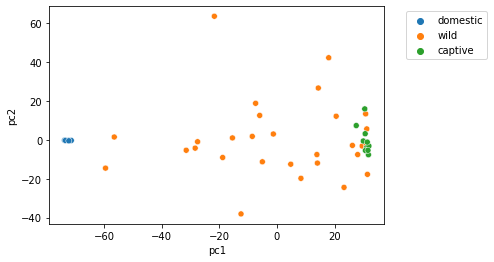

In [4]:
from sim.sum_stats import pca
data.allelify()  # convert from numpy to scikit allel equivilents
pca_data = pca(data.genotypes["all_pops"].to_n_alt(), data.subpops)  # to_n_alt converts to 012 format
sns.scatterplot(x=pca_data["pc1"], y=pca_data["pc2"], hue=pca_data["population"])
plt.legend(bbox_to_anchor=(1.05, 1))

# Using elfi

### Priors

In elfi, SMC, kicks up a fuss if parameters are badly scaled. To overcome this priors are defined using a class ScaledDist (from sim.utils.py).

In [9]:
from sim.utils import ScaledDist
fake_prior = ScaledDist(sampling=scipy.stats.lognorm(s=0.4, loc=0, scale=1),  # elfi will sample and infer from this distribution
                        target=scipy.stats.lognorm(s=0.4, loc=1, scale=np.exp(2.7)))  # elfi will scale up to this distribution in the simulator

The first distribution doesn't really matter, apart from it should be a standardish scale, and it's shape should match the target distribution so it can be scaled up. The second distribution is our actual prior. This means that the only thing that should change in between the distributions are the `loc` and `scale` parameters. To ensure that scaling works as expected, you can plot the target distribution against a scaled set of samples from the sampling distribution, and check the distributions match:

[]

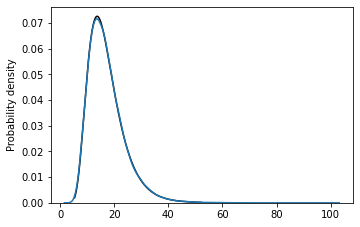

In [10]:
fake_prior.plot(show_scaled_kde=True)

If you haven't run `priors.py`, run it and then you should be able to load the priors with:

In [19]:
with open ("../output/priors.pkl", "rb") as f:
    priors = pickle.load(f)

[]

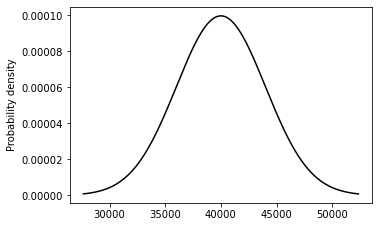

In [20]:
priors["div_time"].plot()

## Real data

The way I got the real data into the same format as the results from the simulations (i.e. an instance of the `GenotypeData` class) is shown below. I thought that although I have done it for the phased data you have given me, in case you want to do it for a different chromosome, or using phasing by a different method, then it may be helpful.

In [ ]:
import allel
from sim.model import GenotypeData
callset = allel.read_vcf("../data/e3_phased.vcf")  #  This is the vcf file you have given me
pop = pd.read_csv("../data/e3_sample_info.csv", usecols=["SOURCE"])["SOURCE"].str.lower().to_numpy().ravel()

subpops = {}
for pop_name in np.unique(pop):
    subpops[pop_name] = np.where(pop == pop_name)[0]

subpops["all_pops"] = np.arange(len(pop))

y_obs = GenotypeData(callset=callset, subpops=subpops, seq_length=44648284)

with open("../data/e3_phased.pkl", "wb") as f:
    pickle.dump(y_obs, f)


Note this will automatically converts the data to biallelic matrices. It also saves the object created using pickle.

In [42]:
import allel
from sim.model import GenotypeData
import pandas as pd
import numpy as np
import pickle
callset = allel.read_vcf("../data/e2_phased.vcf")  #  This is the vcf file you have given me
pop = np.genfromtxt("../data/e2_sample_info.txt", dtype="str", usecols=1)

pop = np.where(pop == "dom", "domestic", pop)
pop = np.where(pop == "cap", "captive", pop)

subpops = {}
for pop_name in np.unique(pop):
    subpops[pop_name] = np.where(pop == pop_name)[0]

subpops["all_pops"] = np.arange(len(pop))

y_obs = GenotypeData(callset=callset, subpops=subpops, seq_length=64340295)

with open("../data/e2_phased.pkl", "wb") as f:
    pickle.dump(y_obs, f)

### Calculate observed statistics

In [ ]:
with open("../data/e2_phased.pkl", "rb") as f:
     test = pickle.load(f)

from sim.sum_stats import simple_sum
observed_sum_stats = simple_sum(y_obs)
observed_sum_stats = {k: [v] for k, v in observed_sum_stats.items()}
observed_sum_stats = pd.DataFrame.from_dict(observed_sum_stats)
observed_sum_stats.to_csv("../output/observed_summary_stats_e2.csv", index = False)